In [1]:
import numpy as np
import scipy.linalg
from scipy.linalg import eig
import scipy.signal
import scipy.optimize
import networkx as nx
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

import random
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from general_graph_utils import *

In [8]:
plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(10,8))
%config InlineBackend.figure_format = 'retina'

In [9]:
def compute_entropy_production(n_ATP, n_ADP, n_P):
    if n_ATP > 0 and n_ADP > 0 and n_P > 0:
        k_plus = n_ATP
        k_minus = n_ADP * n_P
        return np.log(k_plus / k_minus)
    return -np.inf

def compute_initial_entropy(n_ATP, n_ADP, n_P):
    if n_ATP > 0 and n_ADP > 0 and n_P > 0:
        k_plus = n_ATP
        k_minus = n_ADP * n_P
        return np.log(k_plus / k_minus)
    else:
        return -np.inf

def construct_transition_matrix(N, n_ATP, n_ADP, n_P):
    Q = np.zeros((N, N))
    for i in range(N):
        next_i = (i + 1) % N
        prev_i = (i - 1) % N
        
        delta_s = compute_entropy_production(n_ATP, n_ADP, n_P)
        k_minus = 1.0
        k_plus = k_minus * np.exp(delta_s)

        Q[i, next_i] = k_plus if n_ATP > 0 else 0
        Q[i, prev_i] = k_minus if n_ADP > 0 else 0
        Q[i, i] = -(Q[i, next_i] + Q[i, prev_i])
    return Q

def compute_oscillation_coherence(Q):
    eigenvalues = eig(Q, right=False)
    eigenvalues = sorted(eigenvalues, key=lambda x: np.real(x))
    lambda_1 = eigenvalues[-2]  # First nontrivial eigenvalue
    X_R, X_I = np.real(lambda_1), np.imag(lambda_1)
    return X_I / (X_R) if X_R != 0 else np.inf

In [10]:
def gillespie_3d_unicyclic(N, F_init, T_max, n_ATP_init, n_ADP_init, n_P):
    state = 0
    time = 0.0
    n_ATP, n_ADP = n_ATP_init, n_ADP_init

    trajectory = [(time, state, n_ATP, n_ADP)]
    states_visited = [state]
    coherence_record = []
    atp_record = []

    while time < T_max:
        delta_s = compute_entropy_production(n_ATP, n_ADP, n_P)
        k_minus = 1.0
        k_plus = k_minus * np.exp(delta_s)

        forward_rate = k_plus if n_ATP > 0 else 0
        reverse_rate = k_minus if n_ADP > 0 else 0

        total_rate = forward_rate + reverse_rate
        if total_rate == 0:
            break

        tau = -np.log(np.random.rand()) / total_rate
        time += tau

        if time > T_max:
            break

        if np.random.rand() < forward_rate / total_rate:
            state = (state + 1) % N
            n_ATP = max(n_ATP - 1, 0)
            n_ADP += 1
        else:
            state = (state - 1) % N
            n_ATP += 1
            n_ADP = max(n_ADP - 1, 0)

        trajectory.append((time, state, n_ATP, n_ADP))
        states_visited.append(state)
        atp_record.append((time,n_ATP))

        # Compute coherence at this step
        Q = construct_transition_matrix(N, n_ATP, n_ADP, n_P)
        coherence = compute_oscillation_coherence(Q)
        coherence_record.append((time, coherence))

    #print("Visited states:", states_visited)
    return trajectory, coherence_record, atp_record

In [11]:
def plot_trajectory_3d(trajectory, atp_threshold=10):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    times, states, atp_levels, adp_levels = zip(*trajectory)

    points = np.array([times, atp_levels, states]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = plt.Normalize(times[0], times[-1])
    lc = Line3DCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(np.array(times))
    lc.set_linewidth(2)

    ax.add_collection3d(lc)

    depleted_indices = [i for i, atp in enumerate(atp_levels) if atp < atp_threshold]
    if depleted_indices:
        ax.scatter(
            [times[i] for i in depleted_indices],
            [atp_levels[i] for i in depleted_indices],
            [states[i] for i in depleted_indices],
            color='red', marker='*', s=100, label='ATP depleted'
        )

    ax.set_xlabel("Time")
    ax.set_ylabel("ATP Levels")
    ax.set_zlabel("State i")
    ax.set_title("3D Trajectory with Time Color and ATP Depletion Markers")

    ax.set_xlim(min(times), max(times))
    ax.set_ylim(min(atp_levels), max(atp_levels))
    ax.set_zlim(min(states), max(states))

    plt.colorbar(lc, ax=ax, label='Time progression')
    if depleted_indices:
        ax.legend()
    plt.show()

def plot_coherence(coherence_record):
    times, coherences = zip(*coherence_record)
    plt.figure()
    plt.plot(times, coherences, '-o')
    plt.xlabel('Time')
    plt.ylabel('Oscillation Coherence (X_I / X_R)')
    plt.title('Oscillation Coherence over Time')
    plt.grid(True)
    plt.show()
    
def plot_atp(atp_record):
    times, atp = zip(*atp_record)
    plt.figure()
    plt.plot(times, atp, '-o')
    plt.xlabel('Time t')
    plt.ylabel('ATP levels [ATP](t)')
    plt.title('ATP levels over Time')
    plt.grid(True)
    plt.show()

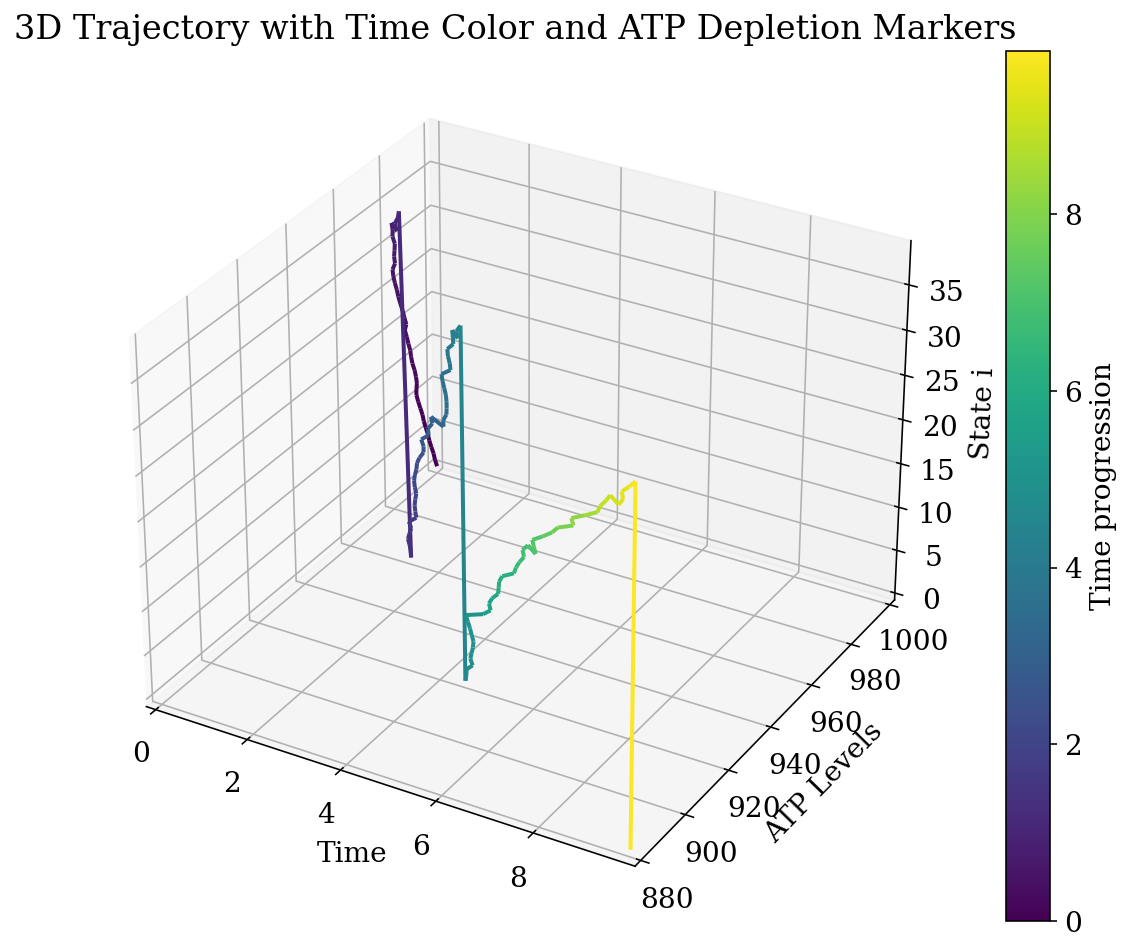

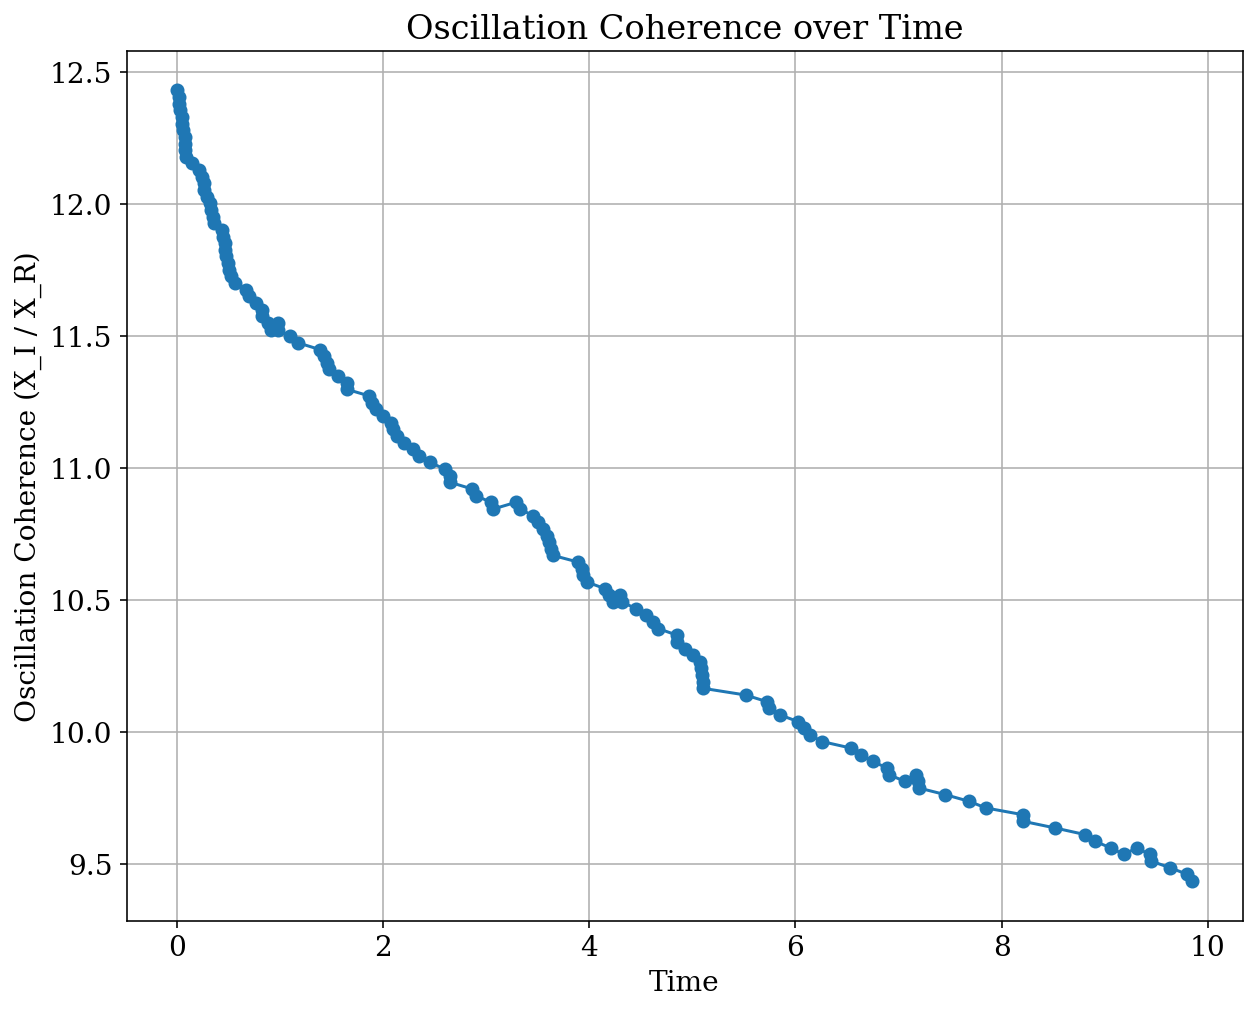

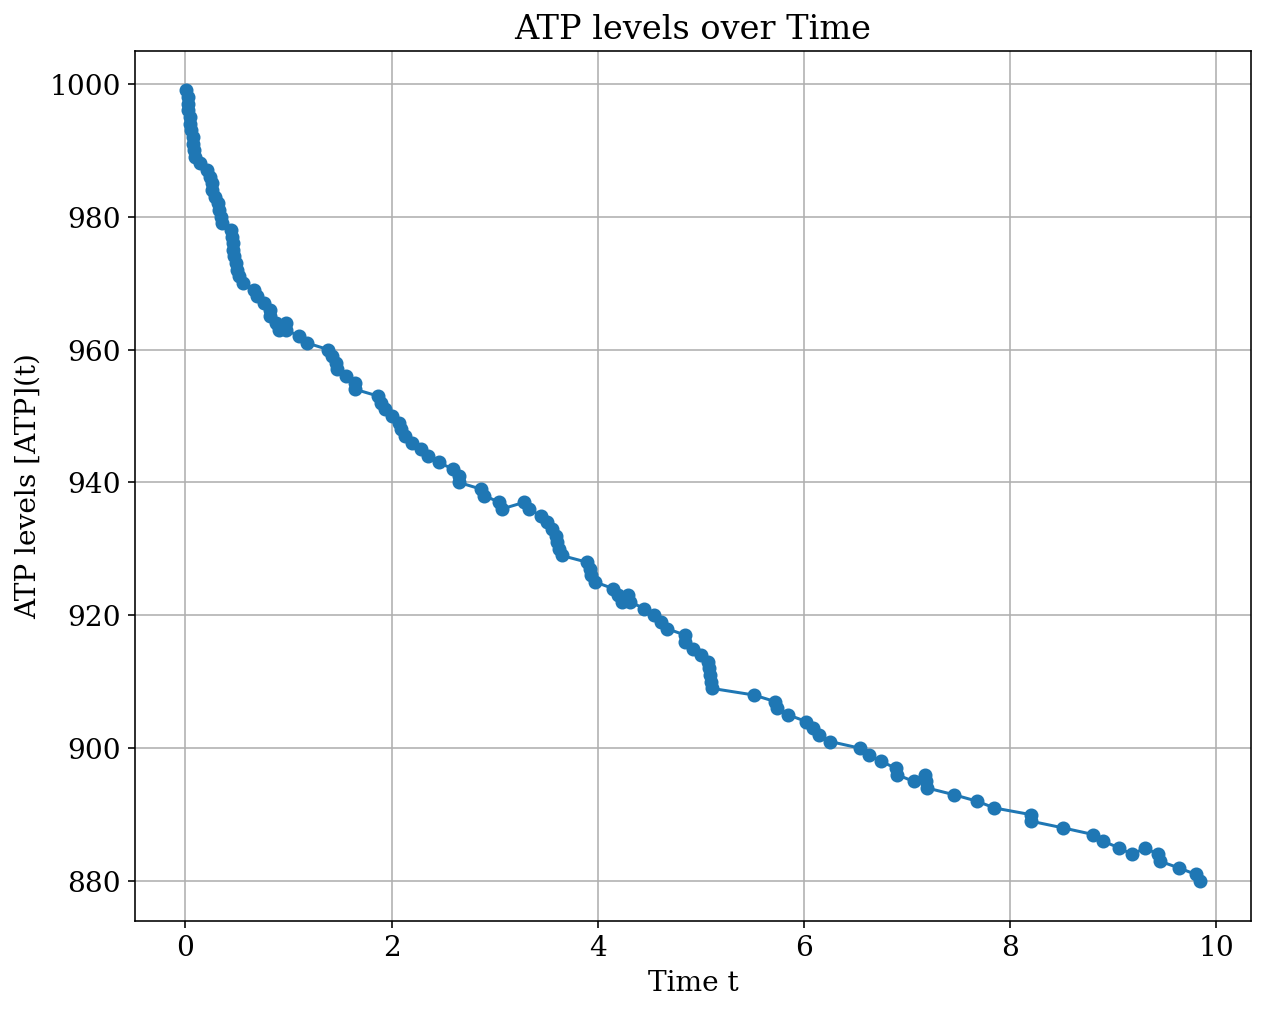

In [12]:
# Parameters
N = 40
F_init = 1.0
T_max = 10
n_ATP_init = 1000
n_ADP_init = 10
n_P = 1

# Run the 3D Gillespie simulation
trajectory, coherence_record, atp_record = gillespie_3d_unicyclic(N, F_init, T_max, n_ATP_init, n_ADP_init, n_P)

# Plot the 3D trajectory
plot_trajectory_3d(trajectory)

# Plot the coherence over time
plot_coherence(coherence_record)

plot_atp(atp_record)

In [13]:
def plot_average_results(avg_times, avg_coherence, avg_atp):
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))

    axs[0].plot(avg_times, avg_coherence, '-o')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Average Coherence')
    axs[0].set_title('Average Oscillation Coherence over Time')
    axs[0].grid(True)

    axs[1].plot(avg_times, avg_atp, '-o')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Average ATP Levels')
    axs[1].set_title('Average ATP Levels over Time')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

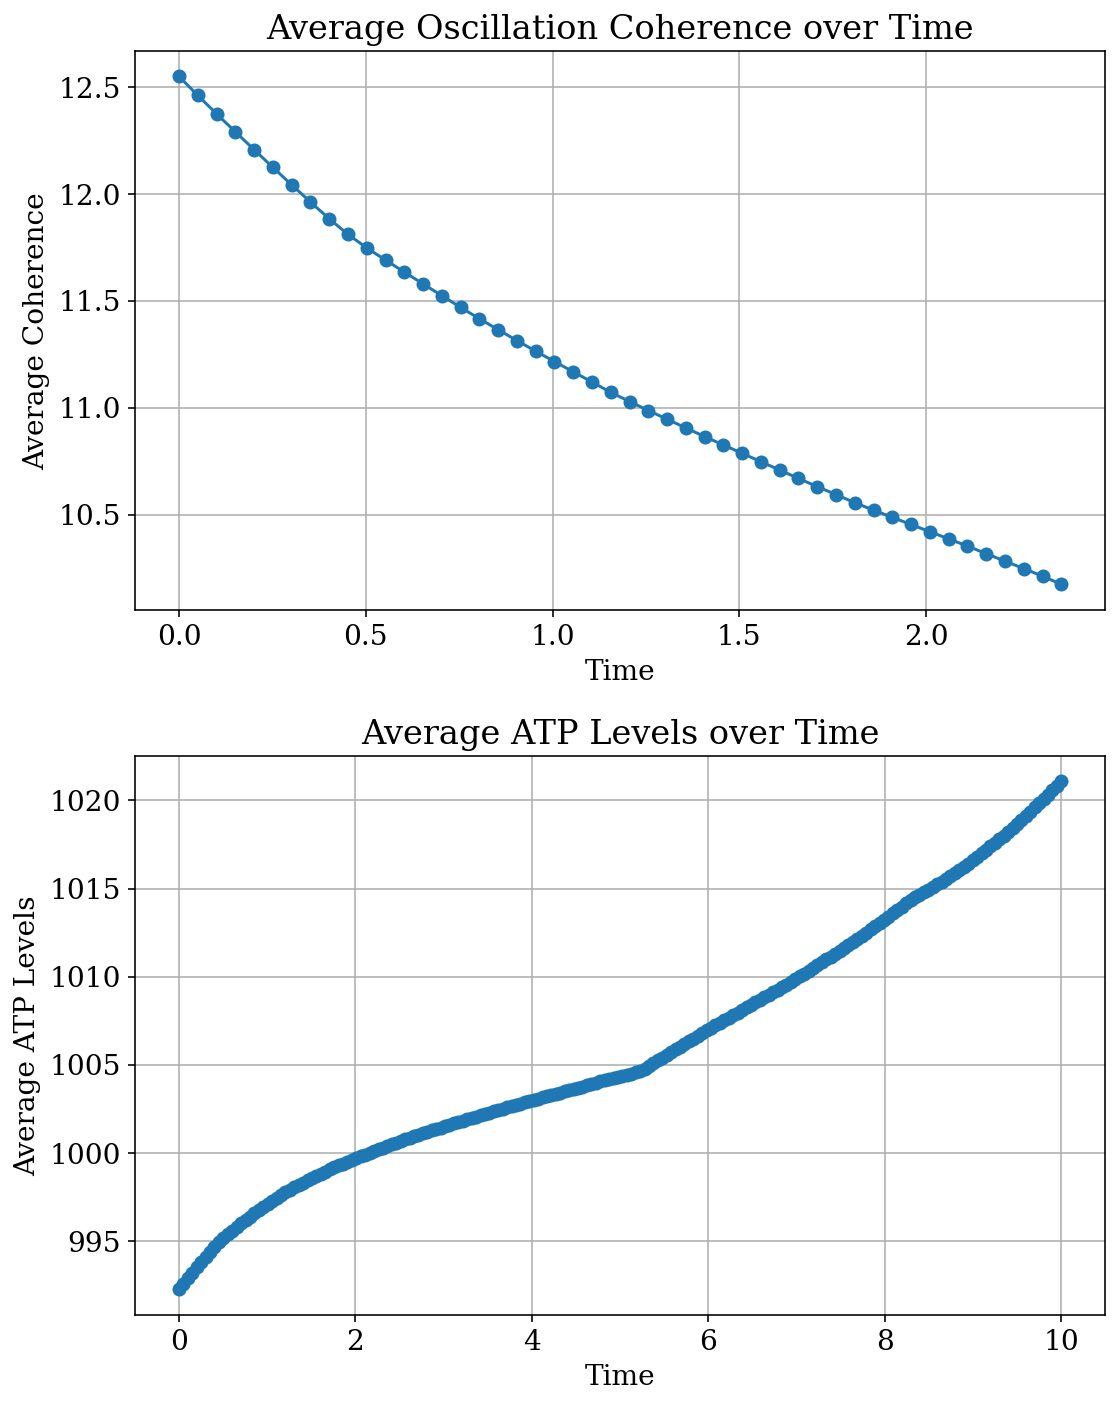

In [14]:
from scipy.interpolate import interp1d

# Parameters
N = 40
F_init = 1.0
T_max = 10
n_ATP_init = 1000
n_ADP_init = 10
n_P = 1000
n_trajectories = 1000

# Common time grid
time_grid = np.linspace(0, T_max, 200)
all_coherence_interp = []
all_atp_interp = []

for _ in range(n_trajectories):
    trajectory, coherence_record, atp_record = gillespie_3d_unicyclic(N, F_init, T_max, n_ATP_init, n_ADP_init, n_P)

    times_coh, coherences = zip(*coherence_record)
    times_atp, atp_levels = zip(*atp_record)

    # Interpolate onto common time grid
    interp_coh = interp1d(times_coh, coherences, bounds_error=False, fill_value='extrapolate')
    interp_atp = interp1d(times_atp, atp_levels, bounds_error=False, fill_value='extrapolate')

    all_coherence_interp.append(interp_coh(time_grid))
    all_atp_interp.append(interp_atp(time_grid))

# Average over trajectories
avg_coherence = np.mean(all_coherence_interp, axis=0)
avg_atp = np.mean(all_atp_interp, axis=0)

# Plot averaged results
plot_average_results(time_grid, avg_coherence, avg_atp)